In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

%matplotlib inline
%config Completer.use_jedi = False

### Загружаем файл в pandas DataFrame и смотрим что в нем лежит

In [217]:
df = pd.read_excel('for_clustering.xlsx')

/home/drev/.virtualenvs/py3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [29]:
print(df.shape)
df.head()

(27508, 45)


,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,0.081007,1,1,60,12,963.01,1,1,2,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,0.036766,1,0,91,15,1534.69,1,1,2,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,0.112974,1,1,13,2,1514.48,1,1,3,3
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,0.027406,1,0,68,35,1872.24,1,1,2,2
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,0.042788,1,1,22,3,557.97,1,1,1,1


In [30]:
df.columns

Index(['Id_client', 'InWeek_amount', 'InWeek_SKU', 'Checkinmonth_average',
       'Checkamount_mean', 'Count_transac', 'Total_amount', 'Total_SKU_qnt',
       'Count_departments', 'Count_shop', 'Count_city', 'Tenure',
       'SKU_meanbytransac', 'Amount_last6mnth', 'Check_qntlast6mnth',
       'SKU_price_mean', 'Gender', 'Age', 'Age_group', 'Interval_visit',
       'Days_pastvisit', 'Cat_householdchem_qnt', 'Cat_householdchem_amount',
       'Cat_householdchem_share', 'Cat_careproducts_qnt',
       'Cat_careproducts_amount', 'Cat_careproducts_share',
       'Cat_toiletries_qnt', 'Cat_toiletries_amount', 'Cat_toiletries_share',
       'Cat_healthwellnes_qnt', 'Cat_healthwellnes_amount',
       'Cat_healthwellnes_share', 'Cat_babyprod_qnt', 'Cat_babyprod_amount',
       'Cat_babyprod_share', 'Communication_3month', 'Response_communcation',
       'SKU_LastMonthqnt', 'Checks_LastMonthqnt', 'Amount_LastMonth',
       'Discount', 'Discount_LastMonth', '_SEGMENT_', 'EM_SEGMENT'],
      dtype

Избавляемся от строк с отсутствующими данными (Нужно с ними работать аккуратнее, но для теста можно и просто отбросить).

Удаляем дублирующиеся строки.

In [31]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
print(df.shape)

(27267, 46)


Ищем колонки, которые нельзя привести к числовому виду

In [32]:
no_num_cols = []
for column in df.columns:
    isnum = pd.to_numeric(df[column][~df[column].isna()], errors='coerce').notnull().all()
    if not isnum:
        no_num_cols.append(column)
        
df[no_num_cols].head()

,Gender,Age_group
0,F,_x0033_5-45
1,F,_x0032_5-35
2,F,_x0032_5-35
3,F,_x0034_5-55
4,F,_x0032_5-35


Колонку 'Gender' преобразуем в числа, а 'Age_group' просто удаляем, это можно делать безболезненно, тк похожая информация есть в колонке 'Age'.

In [33]:
df.drop(columns=['Age_group', 'Id_client', 'index'], inplace=True)


gender = {'M': 0,'F': 1}
df['Gender'] = [gender[item] for item in df['Gender']]

Наконец все колонки превращаем в тип float. Так с ними будет удобнее работать в дальнейшем.

In [34]:
for col in df.columns:
    df[col] = df[col].astype('float')
# df.dtypes
df.describe()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,...,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000,27267.000000
mean,314.727674,31.429677,2.558844,159.693040,82.136795,9585.634168,762.858547,26.738915,3.857703,1.079693,...,0.058615,0.999963,0.547585,40.356695,8.388125,936.866392,0.998056,0.921003,2.003741,2.003741
std,144.464143,11.376459,1.195365,111.530519,62.795554,4712.874709,451.270900,4.036792,2.760003,0.296055,...,0.048948,0.006056,0.497740,23.757077,7.202557,590.731978,0.044046,0.269738,0.776111,0.776111
min,34.474000,2.000000,2.000000,10.239800,4.000000,739.360000,33.000000,7.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,212.991350,23.000000,2.000000,85.936900,39.000000,5888.720000,431.000000,24.000000,2.000000,1.000000,...,0.022685,1.000000,0.000000,22.000000,3.000000,447.800000,1.000000,1.000000,1.000000,1.000000
50%,289.203400,31.000000,2.000000,128.850800,66.000000,8808.650000,673.000000,27.000000,3.000000,1.000000,...,0.047558,1.000000,1.000000,37.000000,6.000000,827.110000,1.000000,1.000000,2.000000,2.000000
75%,385.203400,41.000000,2.000000,199.414400,108.000000,12621.820000,1001.500000,30.000000,5.000000,1.000000,...,0.081679,1.000000,1.000000,56.000000,11.000000,1330.255000,1.000000,1.000000,3.000000,3.000000
max,2180.013700,51.000000,20.000000,1326.115700,990.000000,22748.390000,5058.000000,38.000000,46.000000,9.000000,...,0.887302,1.000000,1.000000,180.000000,112.000000,2478.470000,1.000000,1.000000,3.000000,3.000000


### Данные почистили можно заняться содержимым

Для начала посмотрим на распределения величин в каждой из колонок:

<ipython-input-42-6dd692511787>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax, layout=(rows,cols), bins=200)


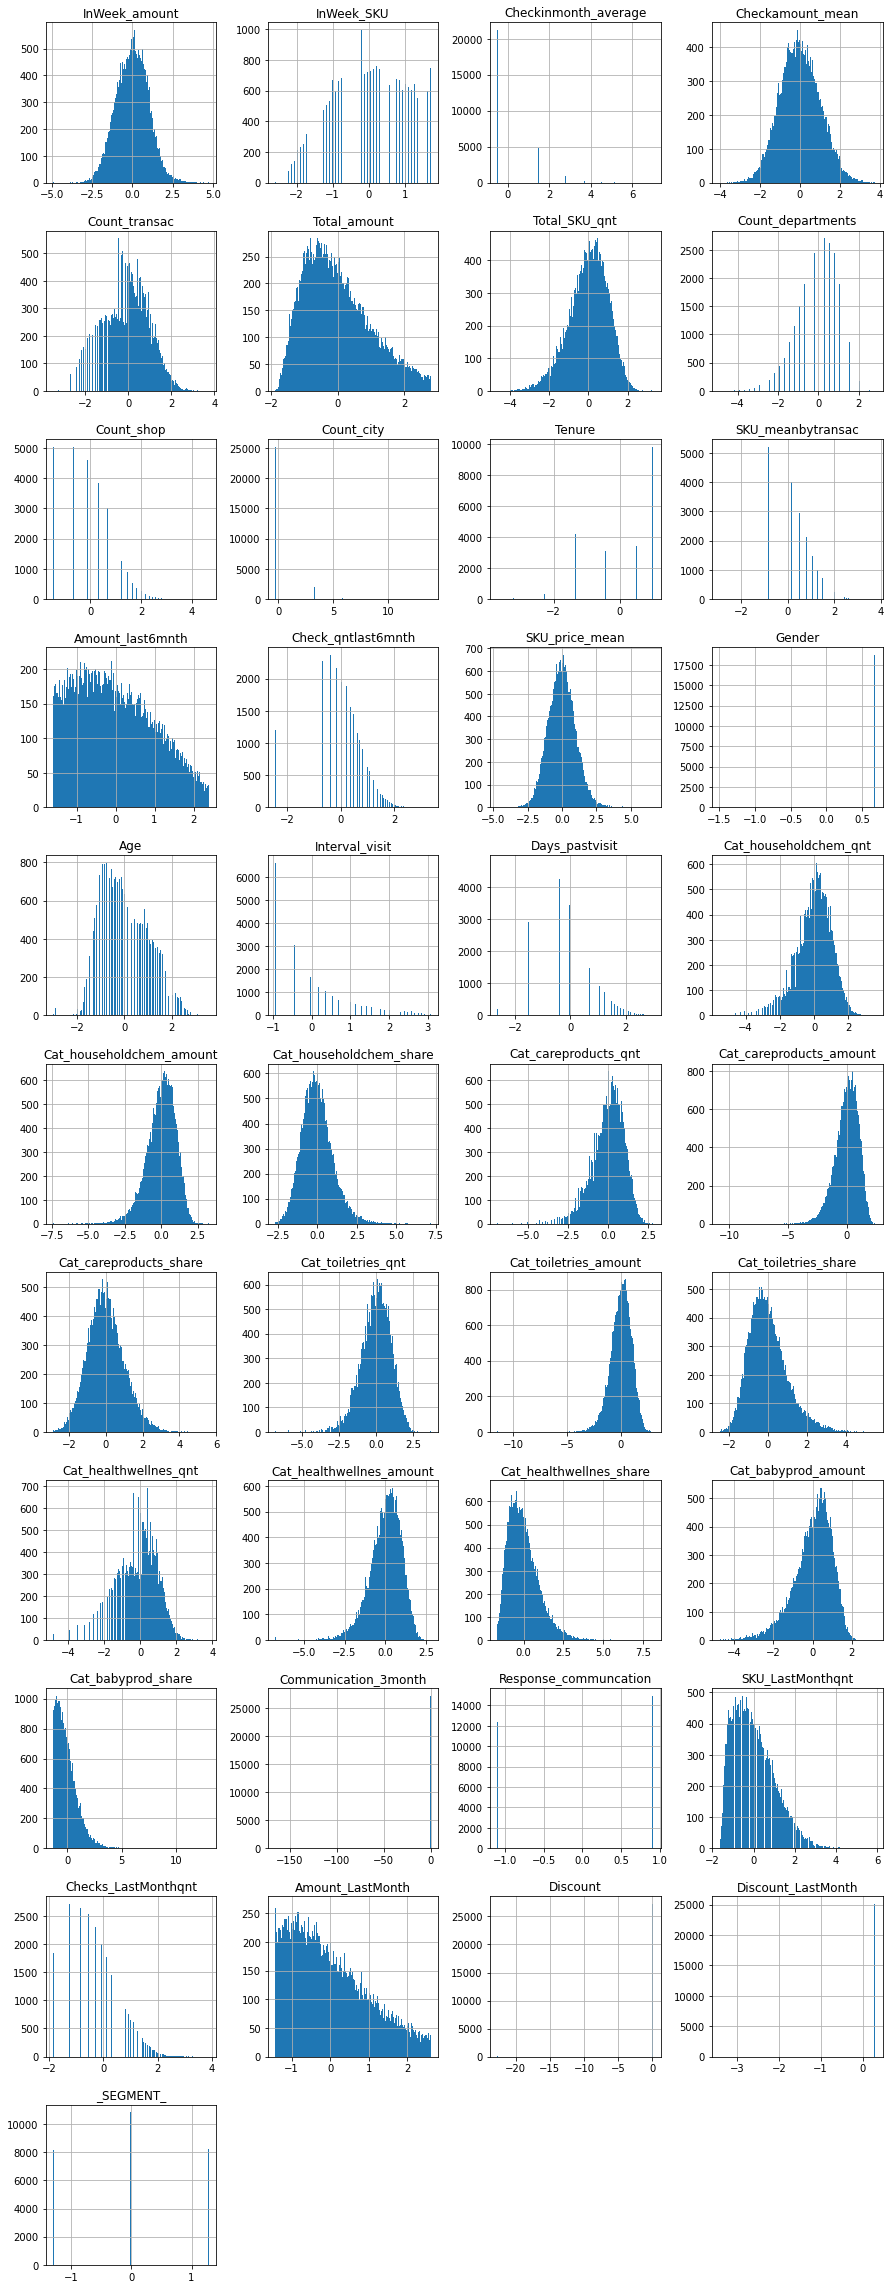

In [42]:
cols = 4
rows = df.shape[1] // cols + 1

figsize_x = 15
figsize_y = figsize_x/cols*rows

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
df.hist(ax=ax, layout=(rows,cols), bins=200)
plt.show()

Распределения величин в большинстве колонок - колоколобразное.

Корректируем ассиметрию распределения, если она есть.

Нормировкой и смещением среднего приводм распределения к виду виду стандартноого нормального распределения.

Нормировка необходима для того, чтобы при дальнейшем анализе не сказывался разный масштаб параметров.

In [36]:
skewed = df.columns[abs(df.skew())>1]
for col in skewed:
    if abs(df[col].skew()) > abs(np.log1p(df[col]).skew()):
        df[col] = np.log1p(df[col])
        
del skewed

In [37]:
for col in df.columns:
    df[col] = (df[col] - df[col].mean())/df[col].std()

In [38]:
df.describe()

,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,Count_city,...,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth,_SEGMENT_,EM_SEGMENT
count,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,...,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04,2.726700e+04
mean,1.013162e-15,-1.167430e-16,5.941385e-16,4.127699e-16,4.502944e-16,-2.751799e-16,1.567692e-15,4.586332e-16,4.336169e-16,-1.227235e-15,...,1.917921e-16,3.700336e-15,2.084696e-17,-9.589604e-17,-4.419557e-16,1.500981e-16,1.446779e-15,2.418248e-16,-7.504907e-17,-7.504907e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.898702e+00,-2.586893e+00,-5.062273e-01,-4.029274e+00,-3.495287e+00,-1.877044e+00,-4.639683e+00,-4.889752e+00,-1.458256e+00,-2.782281e-01,...,-1.255216e+00,-1.651212e+02,-1.100143e+00,-1.656630e+00,-1.836159e+00,-1.418353e+00,-2.265950e+01,-3.414432e+00,-1.293296e+00,-1.293296e+00
25%,-6.944638e-01,-7.409755e-01,-5.062273e-01,-6.898182e-01,-6.528232e-01,-7.844287e-01,-6.162370e-01,-6.784880e-01,-6.712276e-01,-2.782281e-01,...,-7.519183e-01,6.055937e-03,-1.100143e+00,-7.726832e-01,-8.553046e-01,-8.278990e-01,4.412999e-02,2.928637e-01,-1.293296e+00,-1.293296e+00
50%,1.822942e-02,-3.776895e-02,-5.062273e-01,-3.488964e-02,5.226039e-02,-1.648642e-01,8.777612e-02,6.467631e-02,-1.128219e-01,-2.782281e-01,...,-2.127695e-01,6.055937e-03,9.089391e-01,-1.412924e-01,-6.340700e-02,-1.857973e-01,4.412999e-02,2.928637e-01,-4.819912e-03,-4.819912e-03
75%,6.867912e-01,8.412392e-01,-5.062273e-01,6.735780e-01,7.174870e-01,6.442322e-01,7.161614e-01,8.078406e-01,6.742069e-01,-2.782281e-01,...,5.063867e-01,6.055937e-03,9.089391e-01,6.584693e-01,6.993128e-01,6.659342e-01,4.412999e-02,2.928637e-01,1.283656e+00,1.283656e+00
max,4.736735e+00,1.720247e+00,6.997075e+00,3.759446e+00,3.734816e+00,2.792936e+00,3.278110e+00,2.789612e+00,4.669645e+00,1.388426e+01,...,1.299538e+01,6.055937e-03,9.089391e-01,5.877967e+00,3.872589e+00,2.609650e+00,4.412999e-02,2.928637e-01,1.283656e+00,1.283656e+00


Посмотрим на взаимную корреляцию столбцов:

<AxesSubplot:>

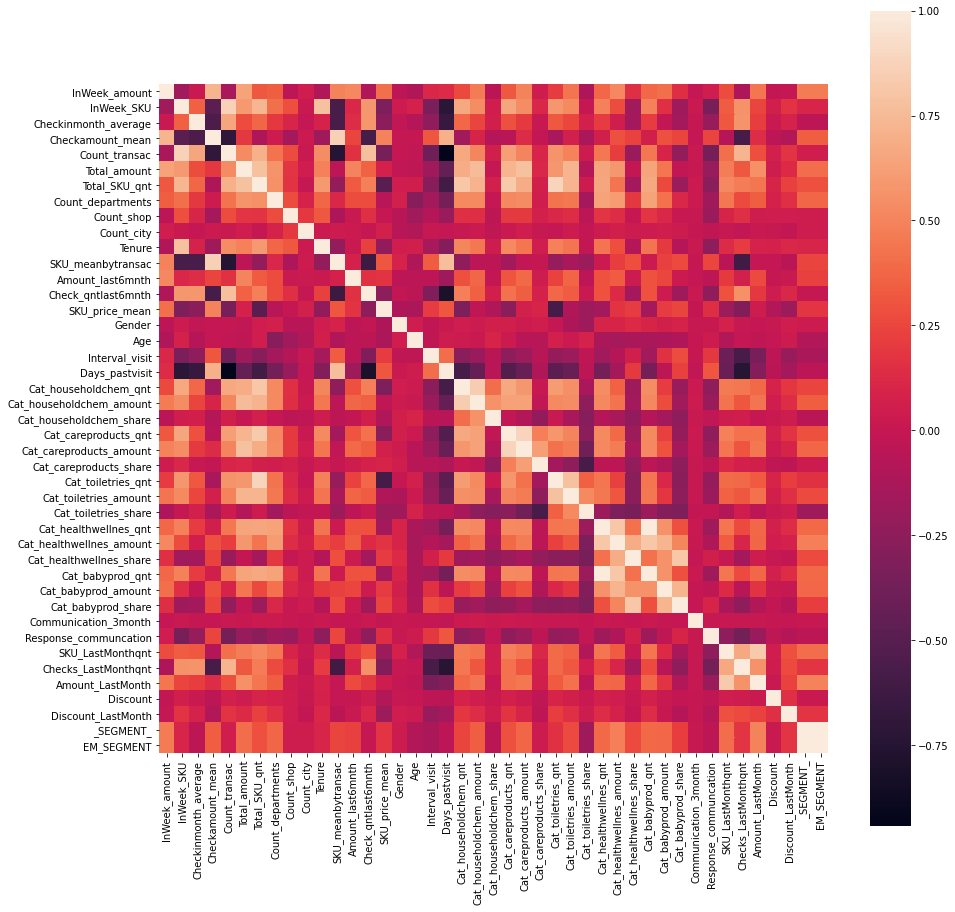

In [39]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, square=True)

Отдельное внимание уделим колонкам которые хорошо (>0.85) коррелируют друг с другом.

От них можно избавиться без сильной потери информации, а чем меньше колонок- тем лучше, тк чем меньше размерность пространства параметров, тем легче будет кластеризовать.

Index(['Count_transac', 'Days_pastvisit', 'Cat_healthwellnes_qnt',
       'Cat_babyprod_qnt', '_SEGMENT_', 'EM_SEGMENT'],
      dtype='object')


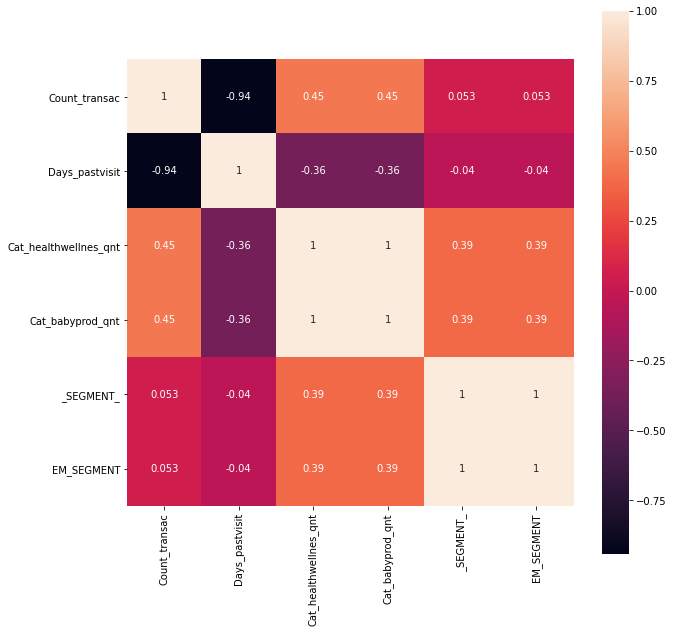

In [40]:
features = df.columns[(corrmat.abs()>0.9).sum()>1]
corrmat_f = df[features].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat_f, square=True, annot=True)

print(features)

In [41]:
df.drop(columns=[
    'EM_SEGMENT',
    'Cat_babyprod_qnt',
], inplace=True)

df.shape

(27267, 41)

### Кластеризация

Данные почистили и нормализовали - можно начинать кластеризовать.
Так как размерность данных все таки большая (>40) воспользуемся t-SNE, а не базовым k-mean.
Для t-SNE, к тому же, не нужно знать число кластеров, которое в нашем случае - неизвестно.

In [ ]:
%%time

from sklearn.manifold import TSNE
X = df[:].values
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(X)
X_embedded.shape

In [ ]:
%%time

X = df[:].values
X_embedded = TSNE(n_components=3, verbose=1).fit_transform(X)
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=3, alpha=0.05)

In [ ]:
%%time
from sklearn.cluster import DBSCAN
X = df[:].values
clustering = DBSCAN(eps=4.2, min_samples=150).fit(X_embedded)
labels = clustering.labels_
del clustering
del X
n_clusters_ = len(set(labels))
print(n_clusters_)
print(set(labels))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,2], c=labels/max(labels), alpha=0.02,cmap='gist_ncar')

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], alpha=0.01, c=labels/max(labels),cmap='gist_ncar')
# plt.scatter(X_embedded[:,0], X_embedded[:,1], s=3, alpha=0.04)

Autoencoder для понижения размерности датасета

In [ ]:
import torch
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, epochs=100, batchSize=128, learningRate=1e-3):
        super(Autoencoder, self).__init__()
        # Encoder Network
        self.encoder = nn.Sequential(nn.Linear(784, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, 3))
        # Decoder Network
        self.decoder = nn.Sequential(nn.Linear(3, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 784),
                                     nn.Tanh())

        self.epochs = epochs
        self.batchSize = batchSize
        self.learningRate = learningRate

        # Data + Data Loaders
        self.imageTransforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        self.data = MNIST('./Data', transform=self.imageTransforms)
        self.dataLoader = torch.utils.data.DataLoader(dataset=self.data,
                                                      batch_size=self.batchSize,
                                                      shuffle=True)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=1e-5)
        self.criterion = nn.MSELoss()

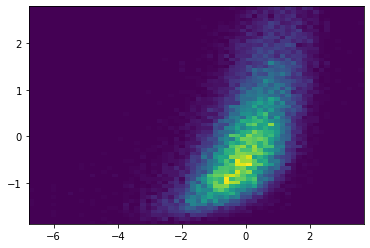

In [48]:
plt.hist2d(df['Cat_toiletries_qnt'], df['Total_amount'], bins=60);

In [212]:
%%time

# X = df[['InWeek_amount', 'InWeek_SKU', 'Checkinmonth_average',
#        'Checkamount_mean', 'Count_transac', 'Total_amount', 'Total_SKU_qnt',
#        'Count_departments', 'Count_shop', 'Count_city', 'Tenure',
#        'SKU_meanbytransac', 'Amount_last6mnth', 'Check_qntlast6mnth',
#        'SKU_price_mean', 'Gender', 'Age', 'Interval_visit',
#        'Days_pastvisit', 'Cat_householdchem_qnt', 'Cat_householdchem_amount',
#        'Cat_householdchem_share', 'Cat_careproducts_qnt',
#        'Cat_careproducts_amount', 'Cat_careproducts_share',
#        'Cat_toiletries_qnt', 'Cat_toiletries_amount', 'Cat_toiletries_share',
#        'Cat_healthwellnes_qnt', 'Cat_healthwellnes_amount',
#        'Cat_healthwellnes_share', 'Cat_babyprod_amount',
#        'Cat_babyprod_share', 'Communication_3month', 'Response_communcation',
#        'SKU_LastMonthqnt', 'Checks_LastMonthqnt', 'Amount_LastMonth',
#        'Discount', 'Discount_LastMonth', '_SEGMENT_']].values
sub_df = df[['Checkamount_mean', 'Count_transac', 'Total_amount', 'Age', 'Interval_visit',
       'Days_pastvisit']]

CPU times: user 1.83 ms, sys: 46 µs, total: 1.88 ms
Wall time: 1.85 ms


In [213]:
X = sub_df.values
X_embedded = TSNE(n_components=2, verbose=1).fit_transform(X)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27267 samples in 0.033s...
[t-SNE] Computed neighbors for 27267 samples in 2.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27267
[t-SNE] Computed conditional probabilities for sample 2000 / 27267
[t-SNE] Computed conditional probabilities for sample 3000 / 27267
[t-SNE] Computed conditional probabilities for sample 4000 / 27267
[t-SNE] Computed conditional probabilities for sample 5000 / 27267
[t-SNE] Computed conditional probabilities for sample 6000 / 27267
[t-SNE] Computed conditional probabilities for sample 7000 / 27267
[t-SNE] Computed conditional probabilities for sample 8000 / 27267
[t-SNE] Computed conditional probabilities for sample 9000 / 27267
[t-SNE] Computed conditional probabilities for sample 10000 / 27267
[t-SNE] Computed conditional probabilities for sample 11000 / 27267
[t-SNE] Computed conditional probabilities for sample 12000 / 27267
[t-SNE] Computed conditional probabilities for sam

(27267, 2)

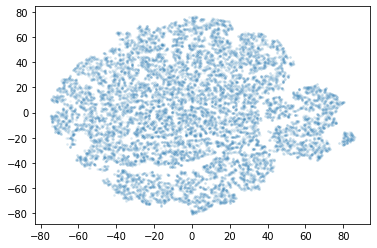

In [214]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=3, alpha=0.05)

In [209]:
clustering = DBSCAN(eps=1.4, min_samples=20).fit(X)
labels = clustering.labels_
del clustering
# del X
n_clusters_ = len(set(labels))
print(n_clusters_)
print(set(labels))

7
{0, 1, 2, 3, 4, 5, -1}


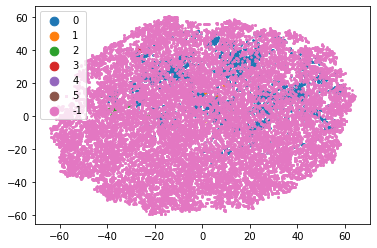

In [210]:
# %matplotlib notebook

fig, ax = plt.subplots()
for label in set(labels):
    mask = labels==label
    ax.scatter(X_embedded[mask][:,0], X_embedded[mask][:,1], s=3, alpha=1, cmap='gist_ncar', label=label)

plt.legend(markerscale=5)
plt.show()

In [211]:
sub_df['labels'] = labels
sub_df['labels'].value_counts()

-1    23893
 0     3259
 2       55
 4       20
 3       17
 1       15
 5        8
Name: labels, dtype: int64

<AxesSubplot:ylabel='labels'>

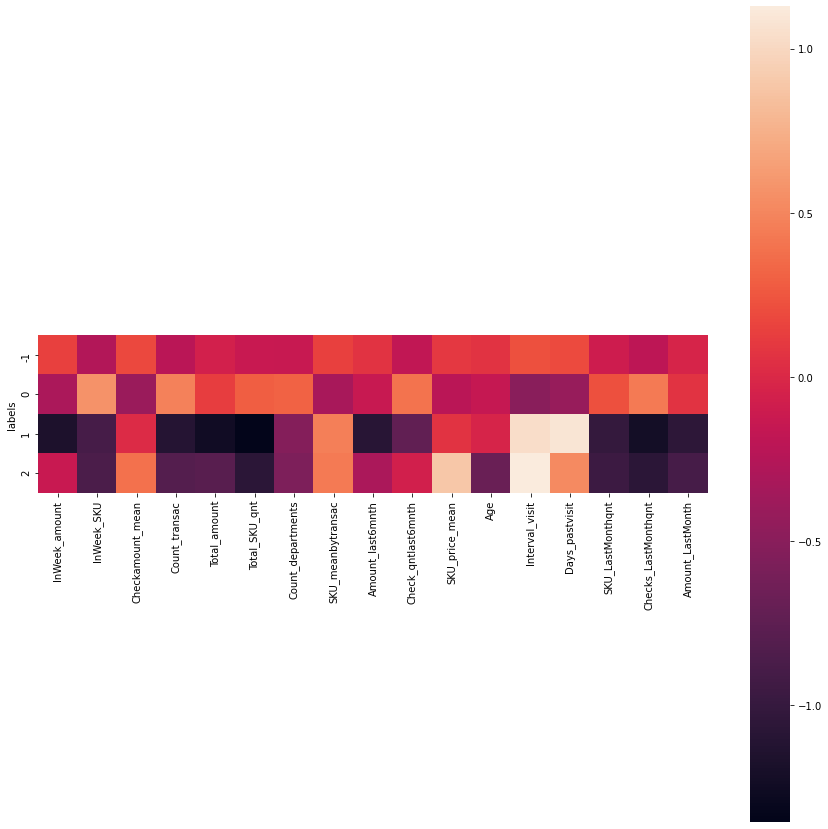

In [204]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(sub_df.groupby(by='labels').mean(), square=True)

In [205]:
one_hot = pd.get_dummies(sub_df['labels'], prefix='label_')
sub_df = sub_df.join(one_hot)

<AxesSubplot:>

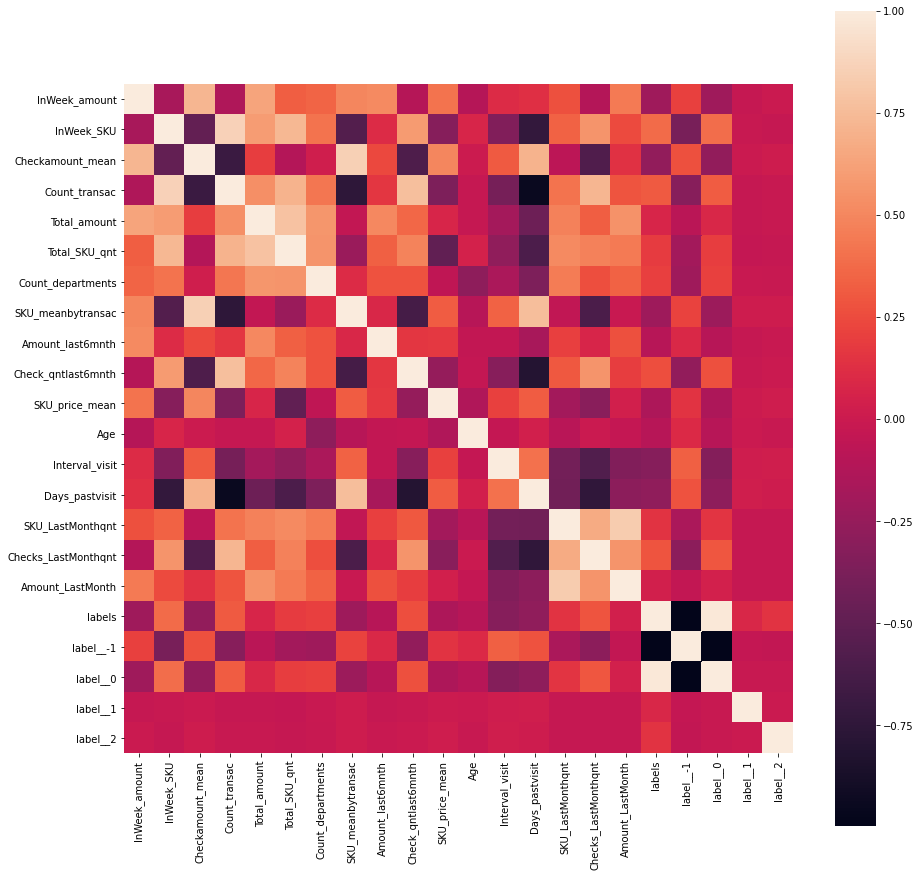

In [206]:
corrmat = sub_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, square=True)

labels
-1    AxesSubplot(0.125,0.125;0.775x0.755)
 0    AxesSubplot(0.125,0.125;0.775x0.755)
 1    AxesSubplot(0.125,0.125;0.775x0.755)
 2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Checkamount_mean, dtype: object

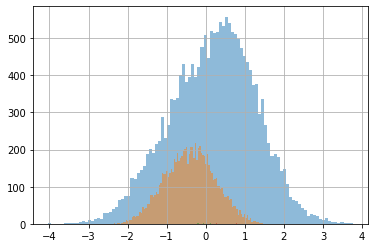

In [207]:
sub_df.groupby(by='labels')['Checkamount_mean'].hist(bins=100, alpha=0.5)

<ipython-input-182-c59c8381203e>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  sub_df.hist(ax=ax, layout=(rows,cols), bins=200)


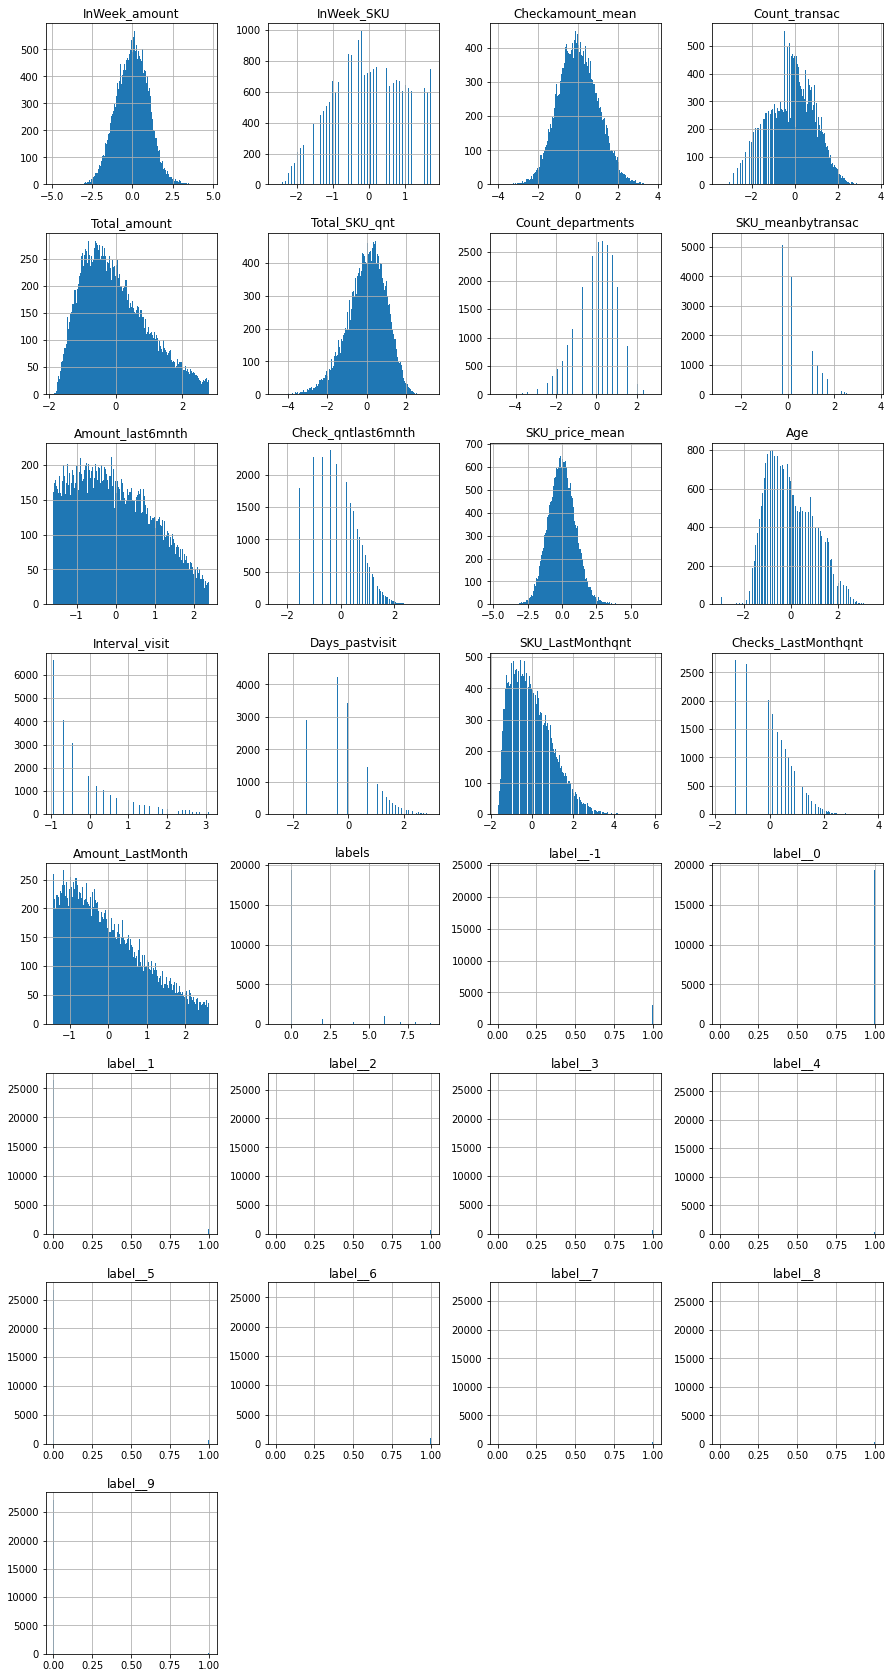

In [182]:
cols = 4
rows = sub_df.shape[1] // cols + 1

figsize_x = 15
figsize_y = figsize_x/cols*rows

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
sub_df.hist(ax=ax, layout=(rows,cols), bins=200)
plt.show()

In [200]:
sub_df

,InWeek_amount,InWeek_SKU,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,SKU_meanbytransac,Amount_last6mnth,Check_qntlast6mnth,...,label__0,label__1,label__2,label__3,label__4,label__5,label__6,label__7,label__8,label__9
0,-0.145971,1.280743,-0.398451,0.848909,0.596849,0.884499,-0.183045,-0.259684,0.530605,1.546970,...,1,0,0,0,0,0,0,0,0,0
1,0.528850,0.401735,-0.440518,0.968797,0.715915,0.751292,0.560119,-0.812463,1.393623,1.236077,...,0,0,0,1,0,0,0,0,0,0
2,0.321136,-1.971587,-0.409840,-1.046066,-1.405035,-2.083067,-0.678488,0.169085,-1.430521,0.207560,...,1,0,0,0,0,0,0,0,0,0
3,0.690466,1.720247,-1.597542,2.511644,2.141094,2.154214,1.551005,-1.591562,0.676772,2.149958,...,0,0,0,0,0,0,0,0,0,0
4,0.182247,-2.059488,-0.311977,-1.241676,-1.507232,-1.444406,-0.183045,0.169085,0.842828,0.721819,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27262,0.356187,-1.268380,0.624236,-0.957846,-0.725823,-1.101150,0.560119,0.519415,0.668664,-0.157312,...,1,0,0,0,0,0,0,0,0,0
27263,-0.673493,-1.268380,0.413829,-1.470028,-1.258685,-0.687426,-0.430767,1.684101,-1.158923,-1.036443,...,1,0,0,0,0,0,0,0,0,0
27264,1.435041,-1.619984,1.172311,-1.241676,-0.440590,-0.605284,-1.917095,0.169085,0.806874,-1.036443,...,1,0,0,0,0,0,0,0,0,0
27265,0.620663,-0.740975,1.070119,-0.874976,-0.206567,-0.496328,0.807841,1.298514,1.038230,-1.550701,...,0,0,0,0,0,1,0,0,0,0


In [218]:
df['Total_amount']/df['Count_transac']

0        104.189160
1         99.689615
2        102.202759
3         48.703812
4         99.289600
            ...    
27503    198.868387
27504    173.981429
27505    300.367600
27506    260.973030
27507    140.606087
Length: 27508, dtype: float64

In [219]:
df['Checkamount_mean']

0        102.9252
1        100.2813
2        102.2027
3         48.8550
4        108.5789
           ...   
27503    193.4472
27504    169.9322
27505    271.0285
27506    254.5211
27507    140.6060
Name: Checkamount_mean, Length: 27508, dtype: float64

In [220]:
!pip install Pandoc

     |████████████████████████████████| 488 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 1.3 MB/s  eta 0:00:01
  Created wheel for Pandoc: filename=pandoc-1.0.2-py3-none-any.whl size=19992 sha256=13165b4d1036b4103edc958048f6555b8c0d6fb3dd40bbdf63e06ca4c61fa36d
  Stored in directory: /home/drev/.cache/pip/wheels/ab/3a/6c/4e657b8601b8e21b8685e467f6a35aff3d77e6d63652c8ce07
Successfully built Pandoc
You should consider upgrading via the '/home/drev/.virtualenvs/py3/bin/python -m pip install --upgrade pip' command.
